In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# Seleccionar variables iniciales para análisis
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report

In [70]:
path_censo_electoral_topes = "data/output/df_enriquecido.csv"
df_enriquecido = pd.read_csv(
    path_censo_electoral_topes,
)

# 1. Predicción de Incumplimientos (Clasificación)

In [71]:
# Definir variables predictoras y objetivo
X = df_enriquecido[['Total de Gastos', '102 - Donaciones de particulares', 'TOPE GASTOS', 'TOPE DONACIONES']]
y = (df_enriquecido['Indice_Cumplimiento_Total'] > 1).astype(int)  # 1 si no cumple

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar modelo Random Forest
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Evaluación
y_pred = model.predict(X_test)

In [72]:
# Calcular y mostrar las métricas
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9932829554995802
Precision: 0.9797979797979798
Recall: 0.941747572815534
Confusion Matrix:
 [[1086    2]
 [   6   97]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      1088
           1       0.98      0.94      0.96       103

    accuracy                           0.99      1191
   macro avg       0.99      0.97      0.98      1191
weighted avg       0.99      0.99      0.99      1191



# Modelo de Éxito Basado en Índice de Cumplimiento

In [73]:
from sklearn.ensemble import GradientBoostingClassifier

In [74]:
# Definir el "éxito" basado en los índices de cumplimiento
y_success = pd.cut(df_enriquecido['Indice_Cumplimiento_Total'], bins=[0, 0.8, 1, float('inf')], labels=[2, 1, 0])

# Entrenar un modelo de Gradient Boosting para predecir el nivel de éxito
model = GradientBoostingClassifier()
model.fit(X_train, y_success)

ValueError: Input X contains NaN.
GradientBoostingClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

# 3. Agrupamiento (Clustering) para Clasificar Campañas por Características y Facilitar la Predicción de Cumplimiento


In [75]:

from sklearn.impute import SimpleImputer


In [76]:

# Seleccionar variables para el clustering
X_cluster = df_enriquecido[['Indice_Gastos', 'Indice_Donaciones', 'Total de Gastos', 'TOPE GASTOS']]


In [77]:

# Crear el imputador y reemplazar los NaNs en X_cluster
imputer = SimpleImputer(strategy='mean')  # Puedes cambiar 'mean' por 'median', 'most_frequent', etc.
X_cluster = imputer.fit_transform(X_cluster)
# Definir el número de clusters
kmeans = KMeans(n_clusters=3, random_state=42)
df_enriquecido['Cluster'] = kmeans.fit_predict(X_cluster)

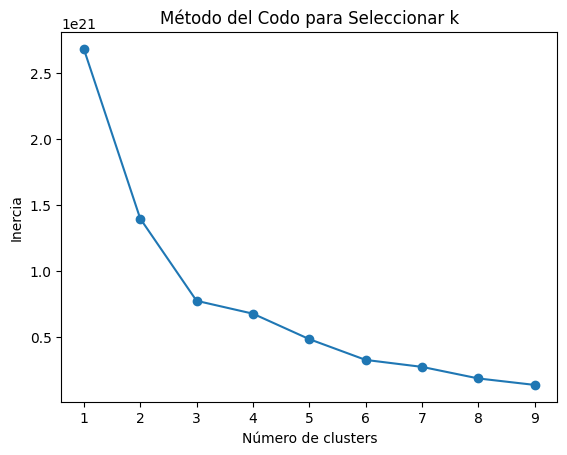

In [78]:
# Probar diferentes números de clusters y calcular la inercia
inercia = []
clusters_range = range(1, 10)
for k in clusters_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_cluster)
    inercia.append(kmeans.inertia_)

# Graficar el método del codo
plt.plot(clusters_range, inercia, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia')
plt.title('Método del Codo para Seleccionar k')
plt.show()

In [79]:
from sklearn.decomposition import PCA


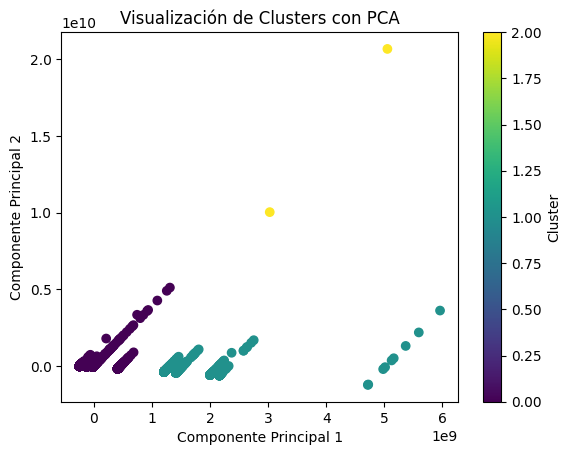

In [80]:

# Reducir las dimensiones a 2D con PCA
pca = PCA(n_components=2)
X_cluster_2D = pca.fit_transform(X_cluster)

# Visualizar los clusters
plt.scatter(X_cluster_2D[:, 0], X_cluster_2D[:, 1], c=df_enriquecido['Cluster'], cmap='viridis', marker='o')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Visualización de Clusters con PCA')
plt.colorbar(label='Cluster')
plt.show()

In [81]:
from sklearn.metrics import silhouette_score


In [82]:

# Calcular la Silhouette Score
silhouette_avg = silhouette_score(X_cluster, df_enriquecido['Cluster'])
print("Silhouette Score:", silhouette_avg)


Silhouette Score: 0.8529857653231304


In [83]:
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm


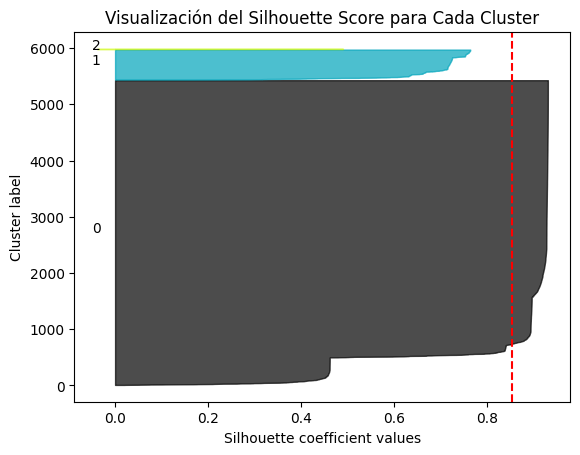

In [84]:

silhouette_values = silhouette_samples(X_cluster, df_enriquecido['Cluster'])
y_lower = 10
for i in range(3):  # Para cada cluster
    cluster_silhouette_values = silhouette_values[df_enriquecido['Cluster'] == i]
    cluster_silhouette_values.sort()

    size_cluster = cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster

    color = cm.nipy_spectral(float(i) / 3)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * size_cluster, str(i))
    y_lower = y_upper + 10

plt.xlabel("Silhouette coefficient values")
plt.ylabel("Cluster label")
plt.title("Visualización del Silhouette Score para Cada Cluster")
plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.show()


# Segmentacion de anomalias

In [89]:
variables_iniciales = [
    "Total de Gastos",
    "Total de Ingresos",
    "Indice_Gastos",
    "Indice_Donaciones",
    "Indice_Cumplimiento_Total",
]
variables_categoricas = ["departamento_normalizado", "ciudad_normalizado"]
df_segment = df_enriquecido[variables_iniciales + variables_categoricas].dropna()


# Codificar variables categóricas
for var in variables_categoricas:
    df_segment[var] = df_segment[var].astype("category").cat.codes


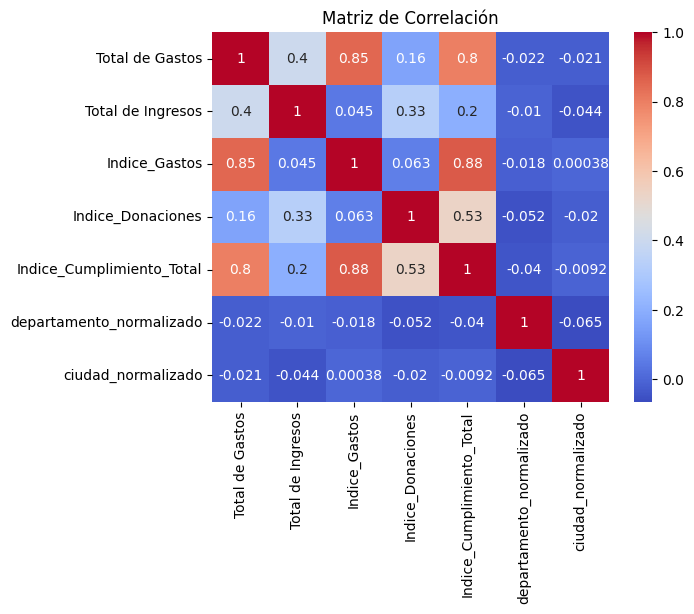

In [90]:

# Análisis de correlación
correlation_matrix = df_segment.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Matriz de Correlación")
plt.show()

Varianza explicada por los componentes principales: [0.41480579 0.17414659]


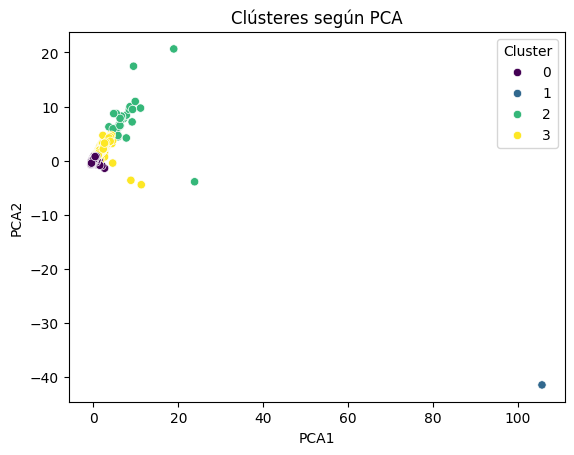

In [91]:


from sklearn.decomposition import PCA
# Escalar los datos
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_segment)

# Reducción de dimensionalidad con PCA
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)
explained_variance = pca.explained_variance_ratio_
print("Varianza explicada por los componentes principales:", explained_variance)

# Crear DataFrame con componentes principales
df_pca = pd.DataFrame(data_pca, columns=['PCA1', 'PCA2'])
df_pca['Departamento'] = df_segment['departamento_normalizado']
df_pca['Ciudades'] = df_segment['ciudad_normalizado']

df_pca['Gasto_Ingreso_Ratio'] = df_segment['Total de Gastos'] / df_segment['Total de Ingresos']

# Reemplazar valores infinitos o NaN (si algún ingreso es 0)
df_pca['Gasto_Ingreso_Ratio'] = df_pca['Gasto_Ingreso_Ratio'].replace([float('inf'), -float('inf')], pd.NA).fillna(0)

# Segmentación con K-Means
kmeans = KMeans(n_clusters=4, random_state=42)
df_pca['Cluster'] = kmeans.fit_predict(data_pca)


# Visualizar los clústeres
sns.scatterplot(data=df_pca, x='PCA1', y='PCA2', hue='Cluster', palette='viridis')
plt.title("Clústeres según PCA")
plt.show()


In [104]:

# Detección de anomalías con Isolation Forest
iso_forest = IsolationForest(contamination=0.1, random_state=20)
df_pca['Anomaly'] = iso_forest.fit_predict(data_pca)

# Identificar anomalías
anomalies = df_pca[df_pca['Anomaly'] == -1]
print("Número de anomalías detectadas:", len(anomalies))

# Guardar resultados
df_pca.to_csv('segmentacion_anomalias_pca.csv', index=False)
anomalies.to_csv('anomalies_pca.csv', index=False)

print("Segmentación y detección de anomalías completadas. Resultados guardados en 'segmentacion_anomalias_pca.csv' y 'anomalies_pca.csv'.")


Número de anomalías detectadas: 566
Segmentación y detección de anomalías completadas. Resultados guardados en 'segmentacion_anomalias_pca.csv' y 'anomalies_pca.csv'.


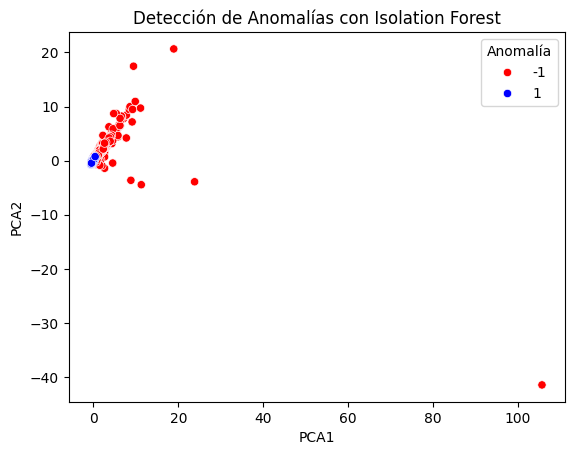

In [105]:
# Visualizar anomalías detectadas
sns.scatterplot(data=df_pca, x='PCA1', y='PCA2', hue='Anomaly', palette={1: 'blue', -1: 'red'})
plt.title("Detección de Anomalías con Isolation Forest")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend(title='Anomalía', loc='best')
plt.show()

In [109]:
df_filtered = df_enriquecido[variables_iniciales + variables_categoricas + ['Nombre']].dropna()

# Codificar variables categóricas
for var in variables_categoricas:
    df_filtered[var] = df_filtered[var].astype('category').cat.codes

# Escalar los datos
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_filtered[variables_iniciales + variables_categoricas])

# Aplicar el modelo Isolation Forest
iso_forest = IsolationForest(contamination=0.1, random_state=20)
df_filtered['Anomaly'] = iso_forest.fit_predict(data_scaled)

# Interpretar resultados
df_filtered['Anomaly_Label'] = df_filtered['Anomaly'].map({1: 'Normal', -1: 'Anomalía'})

# Unir resultados con los datos originales para contexto adicional
df_result = pd.merge(df_enriquecido, df_filtered[['Nombre', 'Anomaly', 'Anomaly_Label']], on='Nombre', how='left')

# Guardar los resultados en un archivo CSV
output_path = 'campañas_anomalias_resultados.csv'
df_result.to_csv(output_path, index=False)

print(f"Resultados guardados en {output_path}.")
print("Número de campañas normales:", (df_filtered['Anomaly'] == 1).sum())
print("Número de campañas anómalas:", (df_filtered['Anomaly'] == -1).sum())

Resultados guardados en campañas_anomalias_resultados.csv.
Número de campañas normales: 5088
Número de campañas anómalas: 566


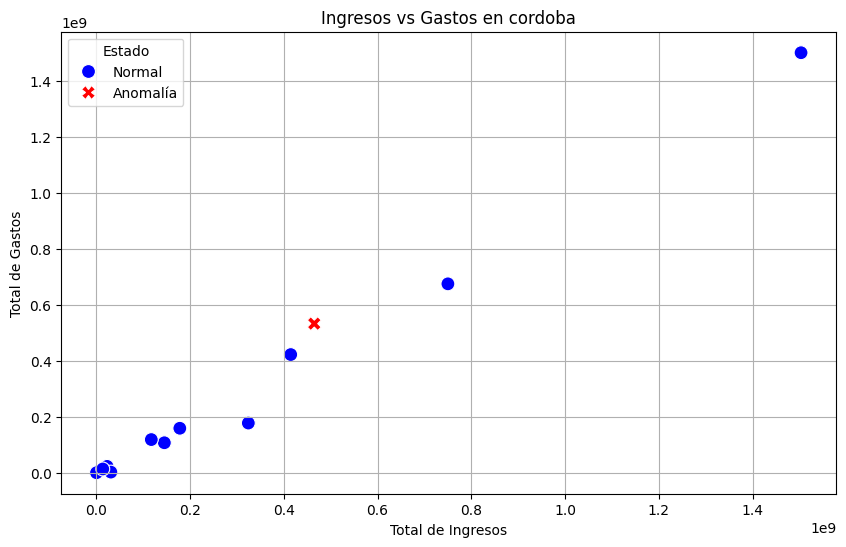

In [111]:
departamento_deseado = "cordoba"  # Cambiar por el nombre del departamento
# df_departamento = df_result[df_result['departamento_normalizado'] == departamento_deseado]

ciudad_deseado='cartagena'
df_departamento = df_result[df_result['ciudad_normalizado'] == ciudad_deseado]

# Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_departamento,
    x='Total de Ingresos',
    y='Total de Gastos',
    hue='Anomaly_Label_x',
    style='Anomaly_Label_x',
    palette={'Normal': 'blue', 'Anomalía': 'red'},
    s=100
)

# Agregar detalles al gráfico
plt.title(f'Ingresos vs Gastos en {departamento_deseado}')
plt.xlabel('Total de Ingresos')
plt.ylabel('Total de Gastos')
plt.legend(title='Estado', loc='upper left')
plt.grid(True)

# Mostrar el gráfico
plt.show()